# XGBoost
Lorem

### Link colab jika tidak bisa diedit https://drive.google.com/file/d/1Xl76vbH8uDGUkNtarcaVYGCb2sSLO4gW/view?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import kagglehub
shubhambathwal_flight_price_prediction_path = kagglehub.dataset_download('shubhambathwal/flight-price-prediction')

print('Data source import complete.')


Mounted at /content/drive


100%|██████████| 4.16M/4.16M [00:00<00:00, 91.8MB/s]

Extracting files...


Data source import complete.


# Flight Price Prediction with XGBoost

# 1. Business Understanding

Kumpulan data berisi informasi tentang opsi pemesanan tiket pesawat dari situs web Easemytrip untuk perjalanan tiket pesawat antara 6 kota metropolitan teratas di India. Ada 300.261 titik data dan 11 fitur dalam kumpulan data yang telah dibersihkan. Tujuan kami adalah untuk (1) menjawab pertanyaan bisnis yang diajukan dan (2) membangun model pembelajaran mesin untuk memprediksi harga tiket pesawat.

## 1.1. Pertanyaan bisnis
- Apakah harga tiket bervariasi tergantung maskapai?
- Bagaimana harga tiket berubah jika dibeli 1 atau 2 hari sebelum keberangkatan?
- Apakah harga tiket berubah berdasarkan waktu keberangkatan dan kedatangan?
- Bagaimana harga tiket berubah jika ada perubahan di tempat keberangkatan dan tujuan?
- Bagaimana harga tiket berbeda antara kelas Ekonomi dan Bisnis?

# 2. Data Understanding

## 2.1. Import Library dan Data

In [ ]:
# !pip install pandas numpy matplotlib seaborn xgboost optuna category-encoders scikit-learn==1.4.2

INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from xgboost import XGBRegressor

# Pre-prccessing
import optuna
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder

# Notebook config
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
palette = ["#1F4E79", "#4F81BD", "#A9CCE3", "#D9EAD3", "#BFBFBF", "#595959", "#D0E0EB", "#8FA3BF"]
sns.set_palette(palette)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

## Sesuaikan dengan folder anda

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Pendat/Clean_Dataset.csv")

## 2.2. Pengecekan Data

In [ ]:
print(f"The dataset has {data.shape[0]} rows and {data.shape[1]} columns.")

The dataset has 300153 rows and 12 columns.


In [ ]:
print(f"The dataset has: {len(data.select_dtypes(include = 'object').columns.to_list())} categorical columns.")
print(f"The dataset has: {len(data.select_dtypes(include = 'number').columns.to_list())} numeric columns.")

The dataset has: 8 categorical columns.
The dataset has: 4 numeric columns.


In [ ]:
data.nunique().sort_values()

,0
class,2
stops,3
departure_time,6
airline,6
arrival_time,6
destination_city,6
source_city,6
days_left,49
duration,476
flight,1561


### Mengecek proporsi nilai yang hilang (missing values)

In [ ]:
data.isnull().mean()

,0
Unnamed: 0,0.0
airline,0.0
flight,0.0
source_city,0.0
departure_time,0.0
stops,0.0
arrival_time,0.0
destination_city,0.0
class,0.0
duration,0.0


Tidak Ada Missing Value

### Menampilkan tipe data (data types)

In [ ]:
data.dtypes

,0
Unnamed: 0,int64
airline,object
flight,object
source_city,object
departure_time,object
stops,object
arrival_time,object
destination_city,object
class,object
duration,float64


### Menampilkan Beberapa Data

In [ ]:
data.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


Kami tidak memerlukan manipulasi data lebih lanjut selain mengecualikan kolom `Tanpa Nama: 0` dan `penerbangan`

In [ ]:
df = data.drop(columns = ['Unnamed: 0', 'flight'], axis = 1).copy()
df.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


## 2.3. EDA (Exploratory Data Analysis)

In [ ]:
df.select_dtypes(include = 'object').describe().T

,count,unique,top,freq
airline,300153,6,Vistara,127859
source_city,300153,6,Delhi,61343
departure_time,300153,6,Morning,71146
stops,300153,3,one,250863
arrival_time,300153,6,Night,91538
destination_city,300153,6,Mumbai,59097
class,300153,2,Economy,206666


### Menampilkan informasi tentang sebaran distribusi kolom price

In [ ]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
duration,300153.0,12.22,7.19,0.83,6.83,11.25,16.17,49.83
days_left,300153.0,26.00,13.56,1.00,15.00,26.00,38.00,49.00
price,300153.0,20889.66,22697.77,1105.00,4783.00,7425.00,42521.00,123071.00


In [ ]:
print(f"Target Skewness and Kurtosis")
print("=" * 30)
print(f"Price Skewness: {df['price'].skew():.4f}")
print(f"Price Kurtosis: {df['price'].kurt():.4f}")

Target Skewness and Kurtosis
Price Skewness: 1.0614
Price Kurtosis: -0.3963


### Kurva Distribusi Colom Price

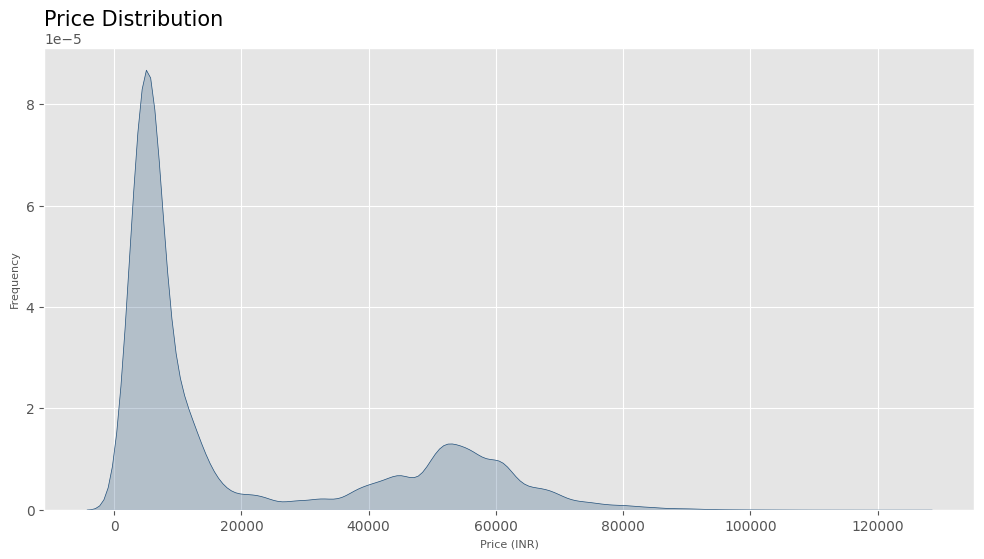

In [ ]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.kdeplot(df.price, fill = True)

ax.set_title("Price Distribution", fontsize = 15, pad = 5, loc = 'left')
ax.set_xlabel("Price (INR)", fontsize = 8)
ax.set_ylabel("Frequency", fontsize = 8)
plt.show()

Our target is right-skewed, which may be caused by the price difference between the flight classes.

### Apakah harganya bervariasi tergantung pada maskapai penerbangan?

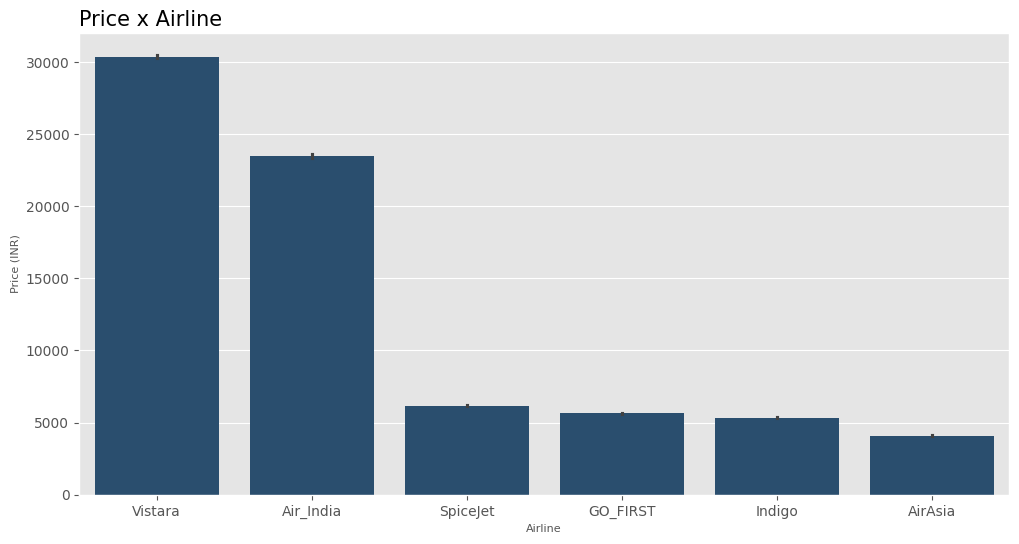

In [ ]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.barplot(x = df.airline, y = df.price, color = '#1F4E79', order = df.groupby('airline')['price'].mean().sort_values(ascending=False).index)
ax.set_title("Price x Airline", fontsize = 15, pad = 5, loc = 'left')
ax.set_xlabel("Airline", fontsize = 8)
ax.set_ylabel("Price (INR)", fontsize = 8)
plt.show()

### Apakah harganya bervariasi tergantung kelas?

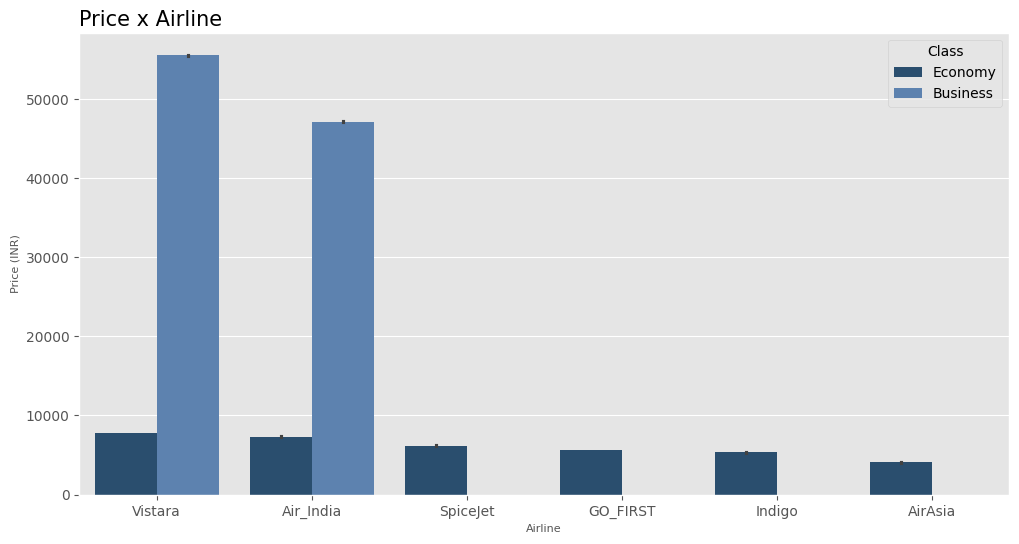

In [ ]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.barplot(x = df.airline, y = df.price, hue = df['class'],order = df.groupby('airline')['price'].mean().sort_values(ascending=False).index)
ax.set_title("Price x Airline", fontsize = 15, pad = 5, loc = 'left')
ax.set_xlabel("Airline", fontsize = 8)
ax.set_ylabel("Price (INR)", fontsize = 8)
ax.legend(title = 'Class')
plt.show()

Vistara dan Air India memiliki harga yang lebih tinggi, tetapi apakah tetap seperti ini jika hanya melihat penerbangan kelas ekonomi?

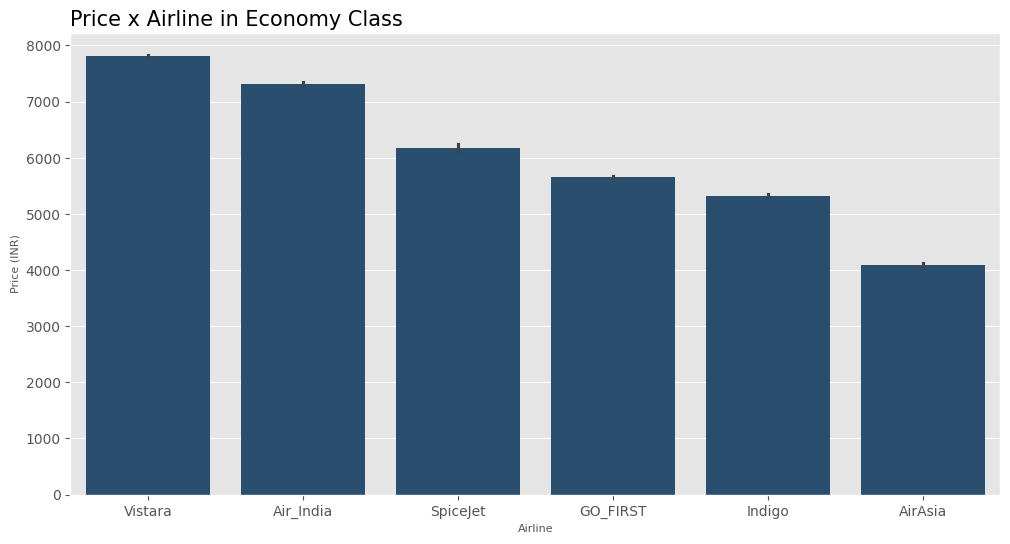

In [ ]:
econ = df[df['class'] == 'Economy']

fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(x = econ.airline, y = econ.price, color = '#1F4E79', order = econ.groupby('airline')['price'].mean().sort_values(ascending=False).index)
ax.set_title("Price x Airline in Economy Class", fontsize = 15, pad = 5, loc = 'left')
ax.set_xlabel("Airline", fontsize = 8)
ax.set_ylabel("Price (INR)", fontsize = 8)
plt.show()

Vistara and Air India still have the higher prices.

### Bagaimana harga terpengaruh bila tiket dibeli hanya 1 atau 2 hari sebelum keberangkatan?

In [ ]:
def days(i):
    if i > 2:
        return 'Over 2 days'
    else:
        return 'Under 2 days'

In [ ]:
df_days = df.copy()
df_days['days'] = df['days_left'].apply(days)

In [ ]:
days = df_days.groupby("days").agg(price_mean = ('price', 'mean'), price_median = ('price', 'median')).reset_index()
days

,days,price_mean,price_median
0,Over 2 days,20757.498484,7347.0
1,Under 2 days,27421.169326,16739.0


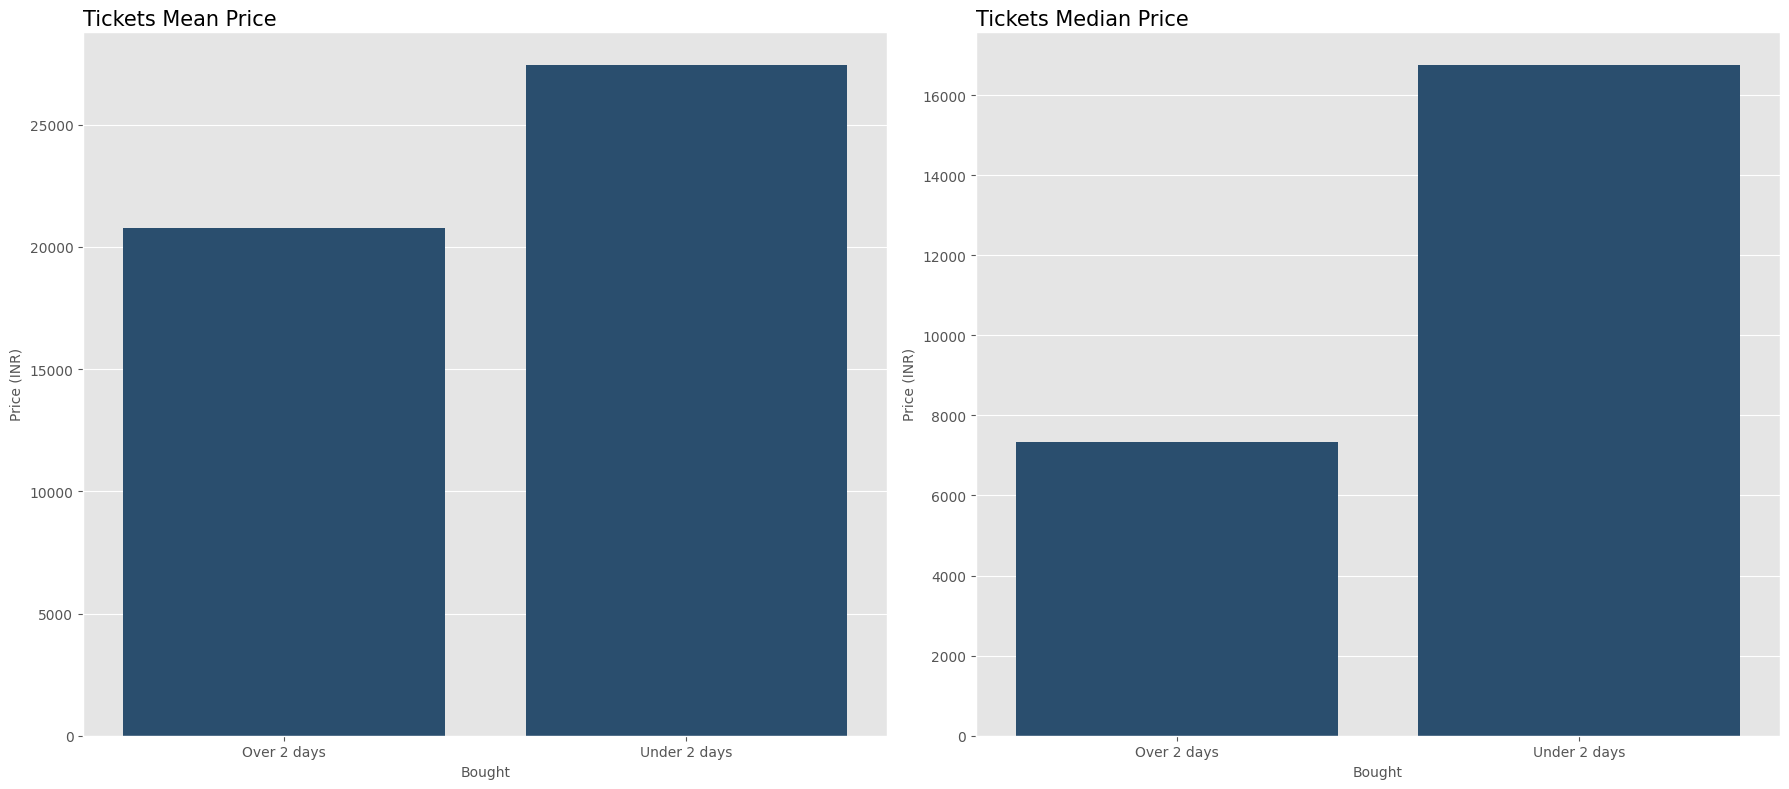

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (18, 8))

sns.barplot(ax = axes[0], x = days.days, y = days.price_mean)
axes[0].set_title("Tickets Mean Price", fontsize = 15, pad = 5, loc = 'left')
axes[0].set_xlabel("Bought", fontsize = 10)
axes[0].set_ylabel("Price (INR)", fontsize = 10)

sns.barplot(ax = axes[1], x = days.days, y = days.price_median)
axes[1].set_title("Tickets Median Price", fontsize = 15, pad = 5, loc = 'left')
axes[1].set_xlabel("Bought", fontsize = 10)
axes[1].set_ylabel("Price (INR)", fontsize = 10)

plt.tight_layout()
plt.show()

The price of airline tickets tends to be higher the closer you are to the flight date.

### Apakah harga tiket berubah berdasarkan waktu keberangkatan dan kedatangan?

In [ ]:
departure = df.groupby(["departure_time"]).agg(price_mean = ('price', 'mean'), price_median = ('price', 'median')).reset_index()
departure

,departure_time,price_mean,price_median
0,Afternoon,18179.203331,6663.0
1,Early_Morning,20370.676718,7212.0
2,Evening,21232.361894,7425.0
3,Late_Night,9295.299387,4499.0
4,Morning,21630.760254,8112.0
5,Night,23062.146808,7813.0


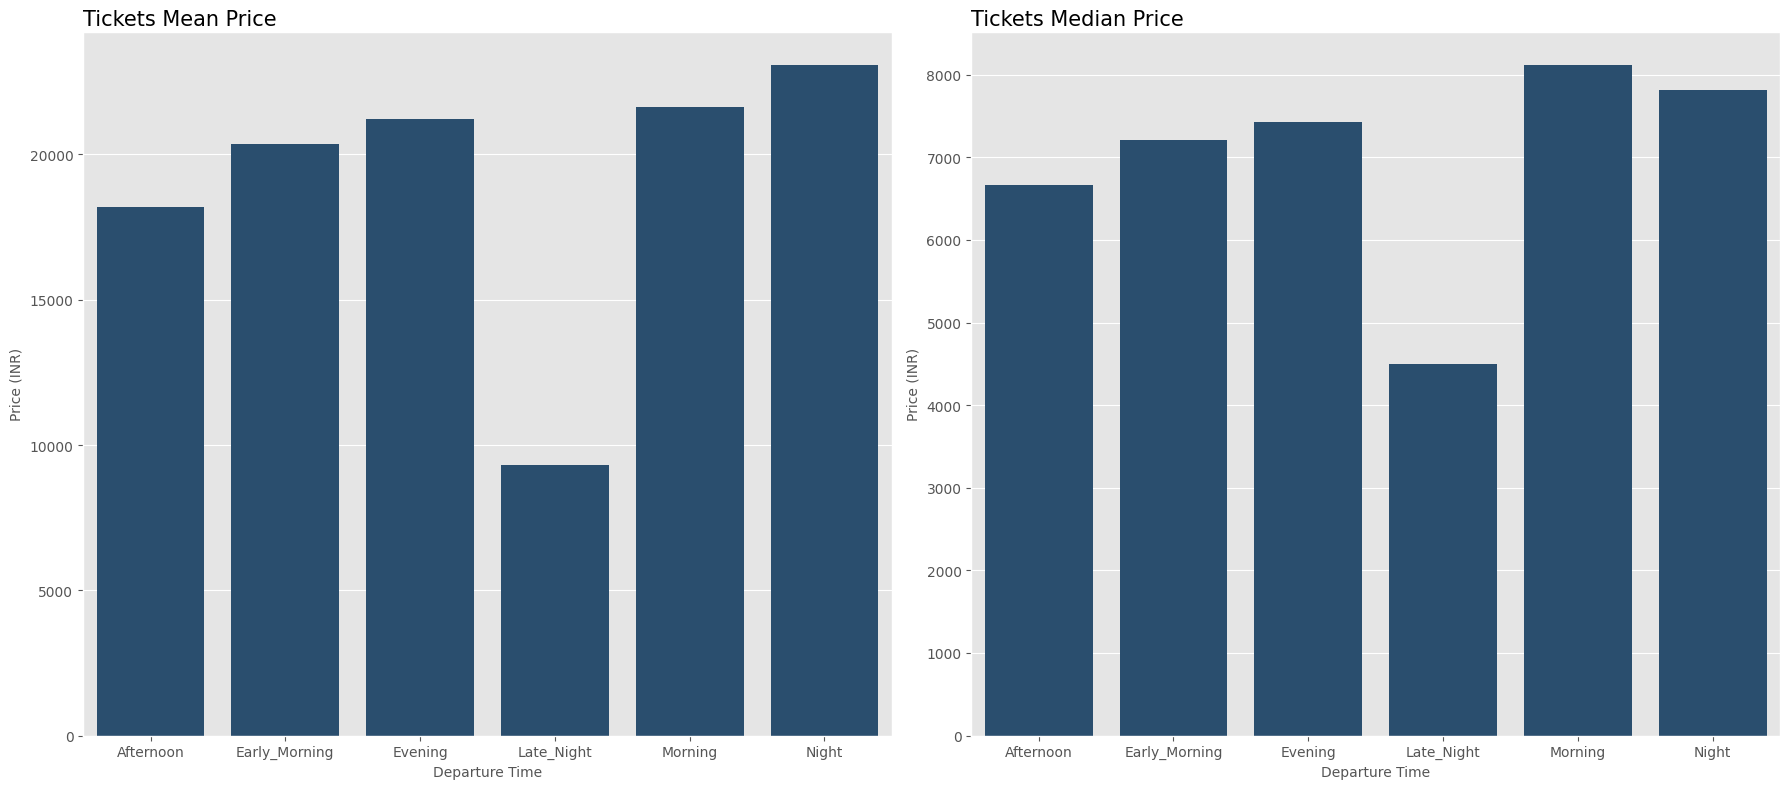

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (18, 8))

sns.barplot(ax = axes[0], x = departure.departure_time, y = departure.price_mean, color = '#1F4E79', order = departure.departure_time)
axes[0].set_title("Tickets Mean Price", fontsize = 15, pad = 5, loc = 'left')
axes[0].set_xlabel("Departure Time", fontsize = 10)
axes[0].set_ylabel("Price (INR)", fontsize = 10)

sns.barplot(ax = axes[1], x = departure.departure_time, y = departure.price_median, color = '#1F4E79', order = departure.departure_time)
axes[1].set_title("Tickets Median Price", fontsize = 15, pad = 5, loc = 'left')
axes[1].set_xlabel("Departure Time", fontsize = 10)
axes[1].set_ylabel("Price (INR)", fontsize = 10)

plt.tight_layout()
plt.show()

Morning and night have the highest prices in departure time.

In [ ]:
arrival = df.groupby(["arrival_time"]).agg(price_mean = ('price', 'mean'), price_median = ('price', 'median')).reset_index()
arrival

,arrival_time,price_mean,price_median
0,Afternoon,18494.598993,6714.0
1,Early_Morning,14993.139521,5800.0
2,Evening,23044.371615,8854.0
3,Late_Night,11284.906078,4867.0
4,Morning,22231.076098,7687.0
5,Night,21586.758341,7584.0


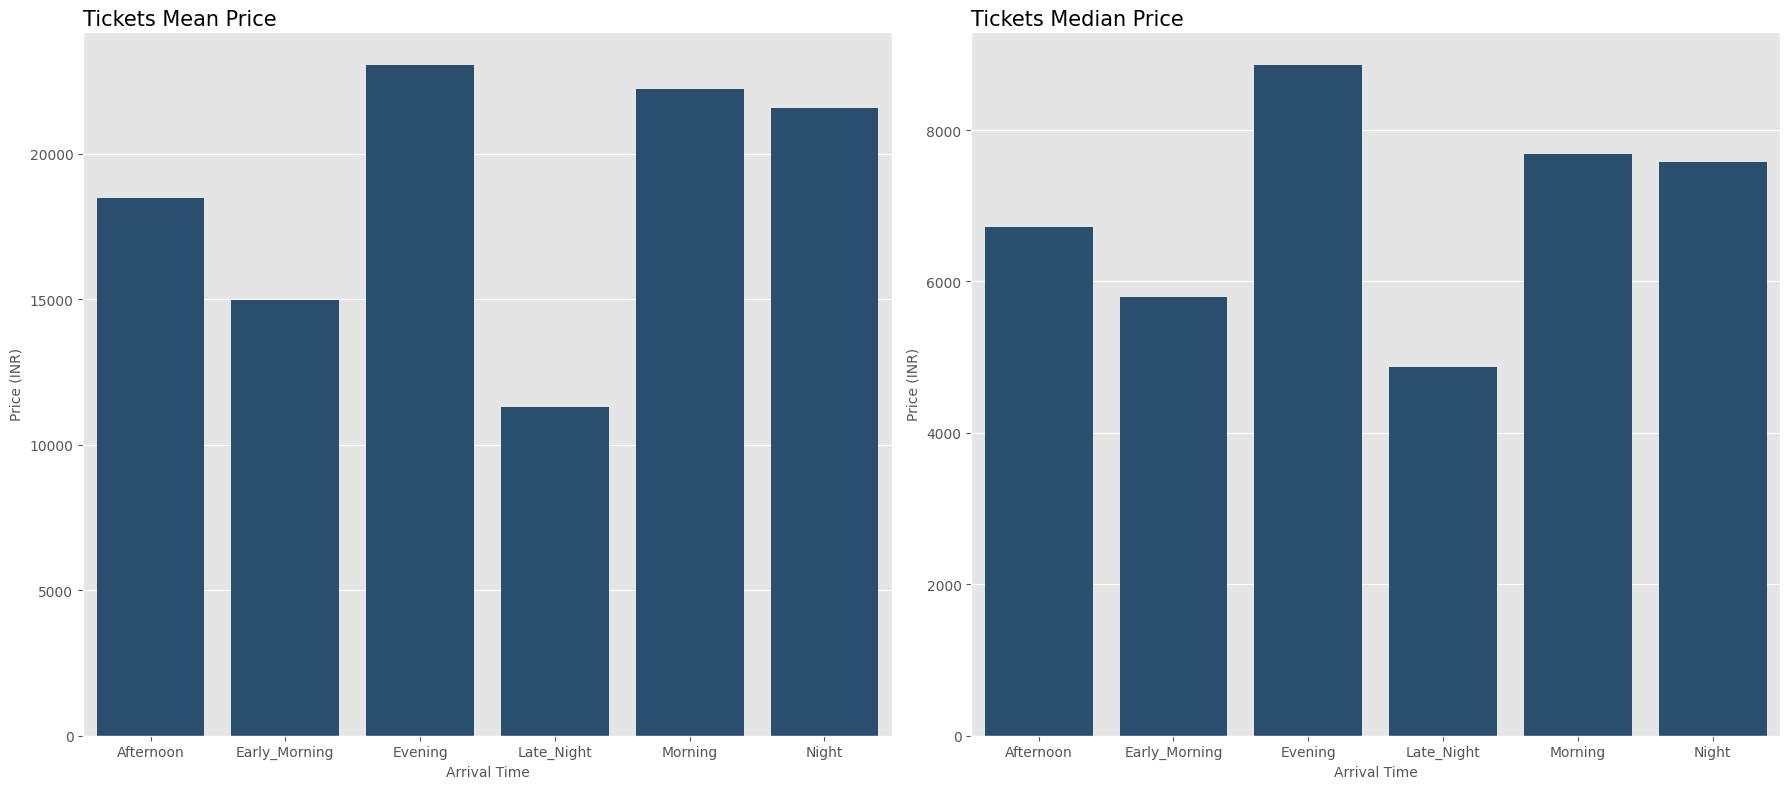

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (18, 8))

sns.barplot(ax = axes[0], x = arrival.arrival_time, y = arrival.price_mean, color = '#1F4E79', order = arrival.arrival_time)
axes[0].set_title("Tickets Mean Price", fontsize = 15, pad = 5, loc = 'left')
axes[0].set_xlabel("Arrival Time", fontsize = 10)
axes[0].set_ylabel("Price (INR)", fontsize = 10)

sns.barplot(ax = axes[1], x = arrival.arrival_time, y = arrival.price_median, color = '#1F4E79', order = arrival.arrival_time)
axes[1].set_title("Tickets Median Price", fontsize = 15, pad = 5, loc = 'left')
axes[1].set_xlabel("Arrival Time", fontsize = 10)
axes[1].set_ylabel("Price (INR)", fontsize = 10)

plt.tight_layout()
plt.show()

Evening and morning have the highest prices in arrival time.

### Bagaimana harga berubah seiring perubahan Sumber dan Tujuan?

In [ ]:
source = df.groupby("source_city").agg(price_mean = ('price', 'mean'), price_median = ('price', 'median')).reset_index()
source

,source_city,price_mean,price_median
0,Bangalore,21469.460575,7488.0
1,Chennai,21995.339871,7846.0
2,Delhi,18951.326639,6840.0
3,Hyderabad,20155.623879,6855.0
4,Kolkata,21746.235679,7958.0
5,Mumbai,21483.818839,7413.0


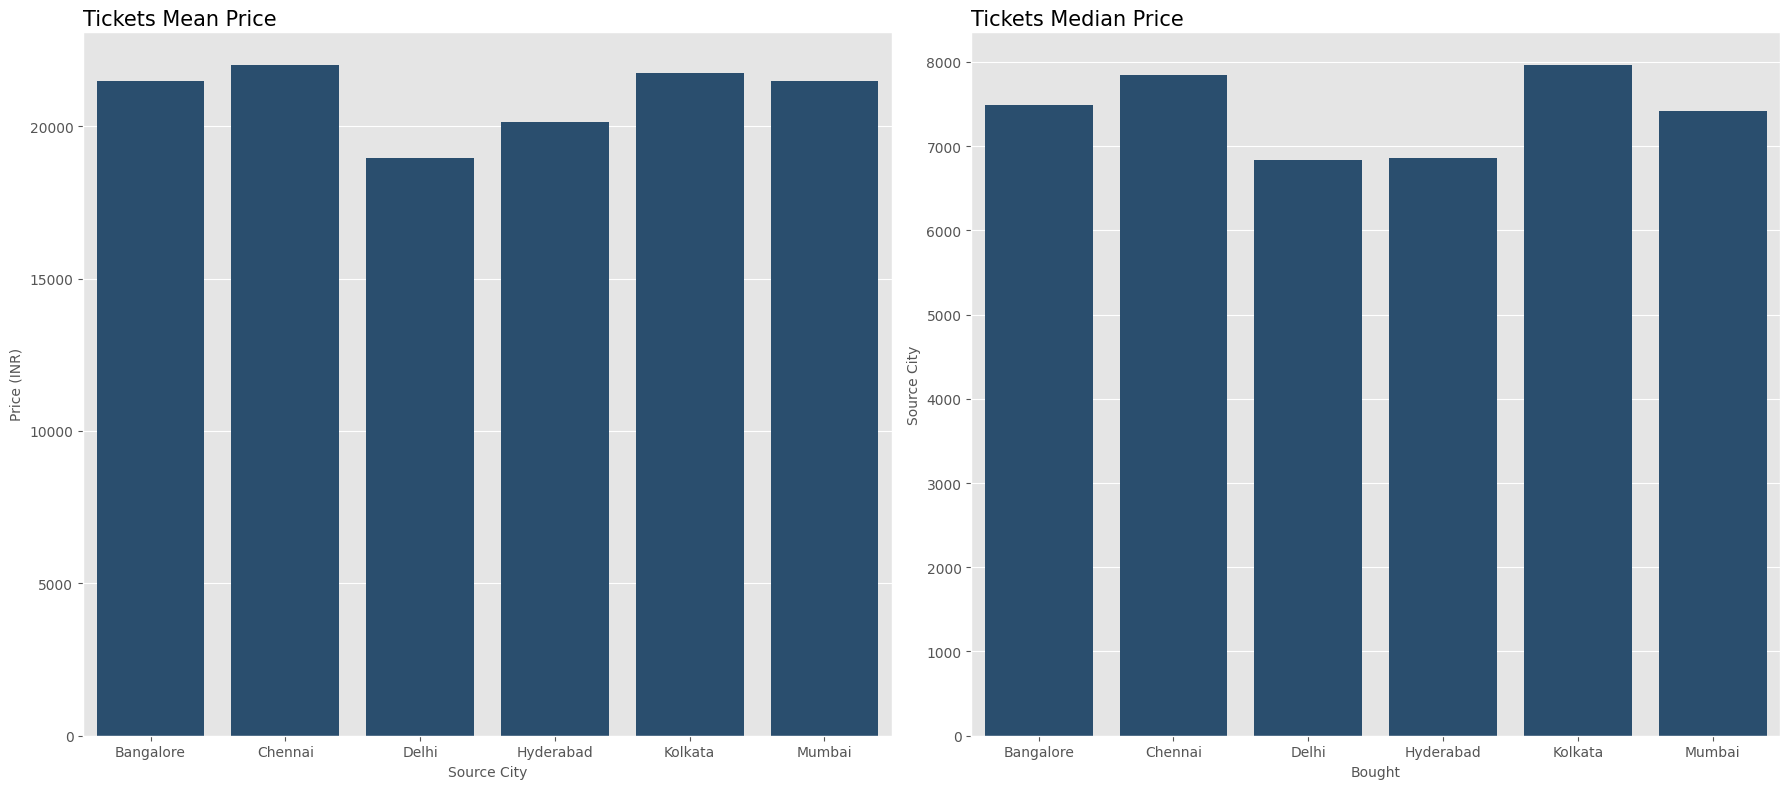

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (18, 8))

sns.barplot(ax = axes[0], x = source.source_city, y = source.price_mean, color = '#1F4E79', order = source.source_city)
axes[0].set_title("Tickets Mean Price", fontsize = 15, pad = 5, loc = 'left')
axes[0].set_xlabel("Source City", fontsize = 10)
axes[0].set_ylabel("Price (INR)", fontsize = 10)

sns.barplot(ax = axes[1], x = source.source_city, y = source.price_median, color = '#1F4E79', order = source.source_city)
axes[1].set_title("Tickets Median Price", fontsize = 15, pad = 5, loc = 'left')
axes[1].set_xlabel("Bought", fontsize = 10)
axes[1].set_ylabel("Source City", fontsize = 10)

plt.tight_layout()
plt.show()

In [ ]:
destination = df.groupby("destination_city").agg(price_mean = ('price', 'mean'), price_median = ('price', 'median')).reset_index()
destination

,destination_city,price_mean,price_median
0,Bangalore,21593.955784,7425.0
1,Chennai,21953.323969,7900.0
2,Delhi,18436.767870,6521.0
3,Hyderabad,20427.661284,7548.0
4,Kolkata,21959.557556,7767.0
5,Mumbai,21372.529469,7496.0


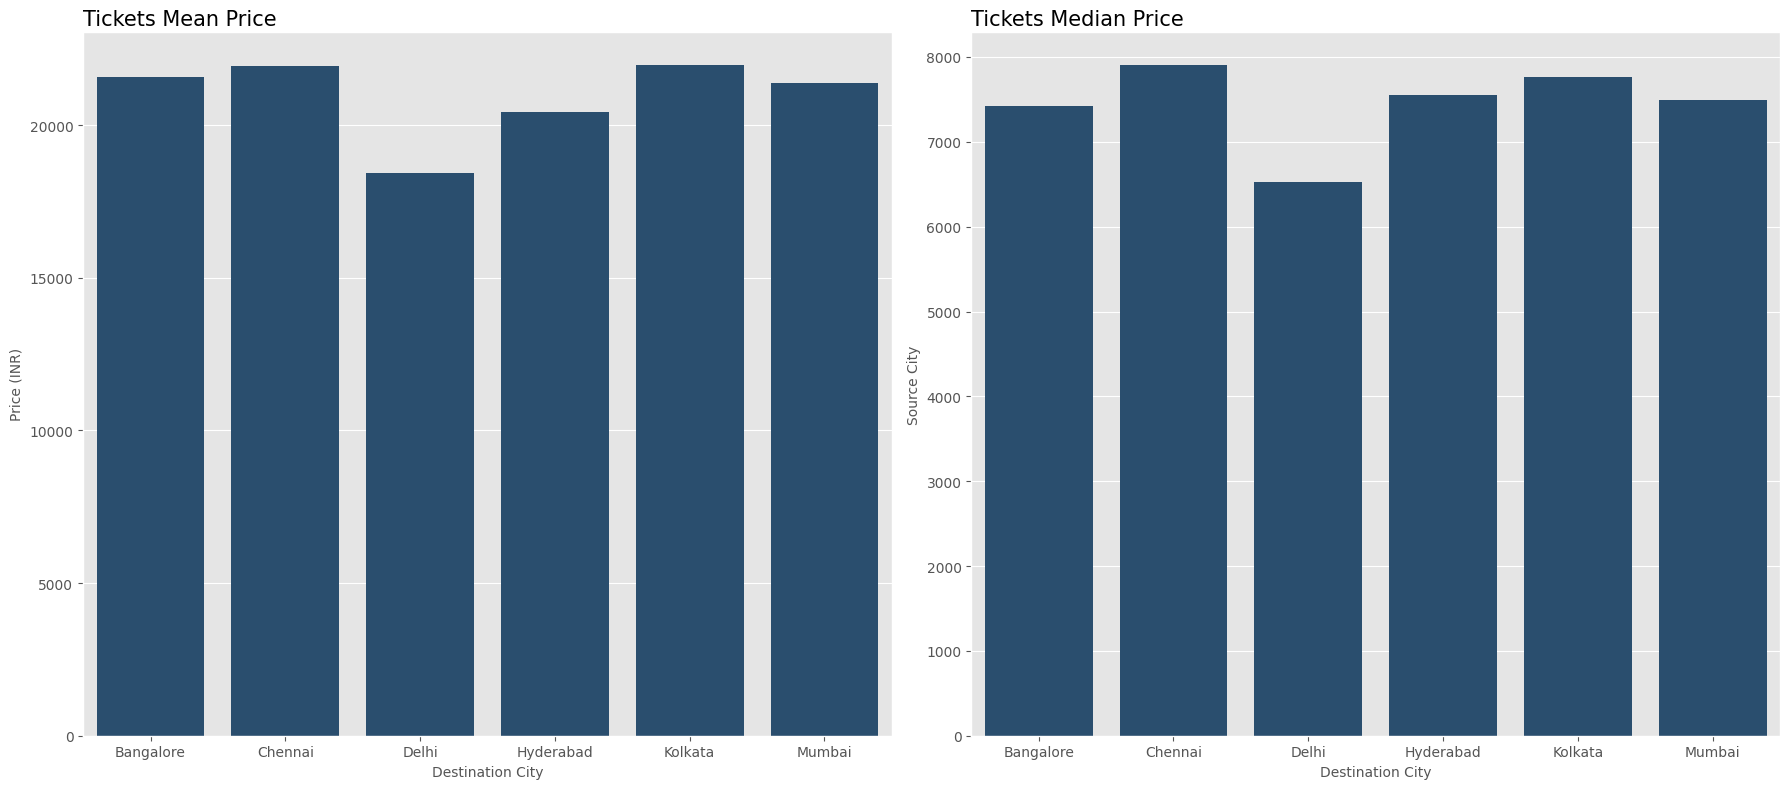

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (18, 8))

sns.barplot(ax = axes[0], x = destination.destination_city, y = destination.price_mean, color = '#1F4E79', order = destination.destination_city)
axes[0].set_title("Tickets Mean Price", fontsize = 15, pad = 5, loc = 'left')
axes[0].set_xlabel("Destination City", fontsize = 10)
axes[0].set_ylabel("Price (INR)", fontsize = 10)

sns.barplot(ax = axes[1], x = destination.destination_city, y = destination.price_median, color = '#1F4E79', order = destination.destination_city)
axes[1].set_title("Tickets Median Price", fontsize = 15, pad = 5, loc = 'left')
axes[1].set_xlabel("Destination City", fontsize = 10)
axes[1].set_ylabel("Source City", fontsize = 10)

plt.tight_layout()
plt.show()

Kolkata and Chennai have the most expensive tickets.

### Matriks Korelasi

In [ ]:
dummies = pd.get_dummies(df, prefix = ['airline',
 'source_city',
 'departure_time',
 'stops',
 'arrival_time',
 'destination_city',
 'class'], dtype = int)
corr = dummies.corr()

In [ ]:
corr.loc['price'].sort_values(ascending = False)

,price
price,1.000000
class_Business,0.937860
airline_Vistara,0.360816
duration,0.204222
stops_one,0.199913
airline_Air_India,0.070041
arrival_time_Evening,0.056408
departure_time_Night,0.041768
arrival_time_Morning,0.030379
destination_city_Kolkata,0.020956


## The highlights:

- Kelas bisnis memiliki korelasi yang cukup tinggi dengan harga.
- Vistara memiliki korelasi positif tertinggi dengan harga, yang merupakan korelasi tertinggi di antara maskapai penerbangan lainnya.
- Durasi dan pemberhentian tunggal juga memiliki korelasi yang signifikan.

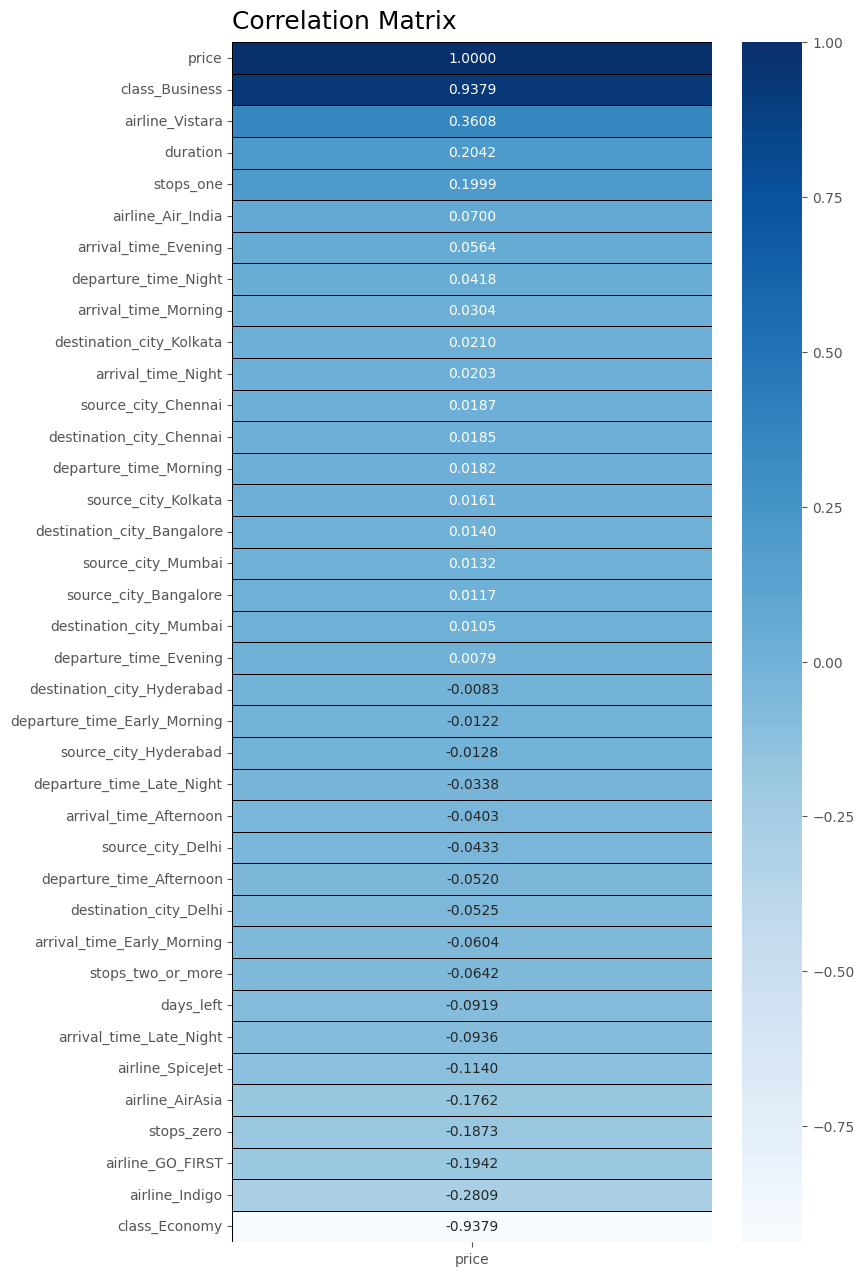

In [ ]:
fig = plt.figure(figsize = (6, 12))
ax = fig.add_axes([0, 0, 1, 1])
sns.heatmap(corr[['price']].sort_values(by = 'price', ascending = False), annot = True, fmt = '.4f', cmap = 'Blues', linecolor='black', linewidths=0.5)
ax.set_title("Correlation Matrix", fontsize = 18, pad = 10, loc = 'left')
plt.show()

# 3. Data Preparation

In [ ]:
features = df.drop(columns = ['price'], axis = 1).columns.to_list()
target = 'price'

X = df[features]
y = df[target]

### Tahap 1: Memisahkan 20% data sebagai test set
### Tahap 2: Memisahkan 25% dari sisa data menjadi validation set
* 60% untuk training set
* 20% untuk validation set
* 20% untuk test set

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split
 (X, y, test_size=0.20, random_state=21)

X_train, X_val, y_train, y_val = train_test_split
 (X_temp, y_temp, test_size = 0.25, random_state=21)

In [ ]:
cat_features = X_train.select_dtypes(exclude = 'number').columns.to_list()
num_features = X_train.select_dtypes(include = 'number').columns.to_list()

In [ ]:
cat_transformer = Pipeline([
    ('imput', SimpleImputer(strategy = "most_frequent")),
    ('enconder', TargetEncoder())
])

num_transformer = Pipeline([
    ('imput', SimpleImputer(strategy = 'median')),
])

preprocessor = ColumnTransformer(
    transformers = [
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ])

# 4. Modeling

## 4.1. The base model

In [ ]:
model = XGBRegressor(objective='reg:squarederror', random_state = 21)

reg = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)
])

reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imput',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('enconder',
                                                                   TargetEncoder())]),
                                                  ['airline', 'source_city',
                                                   'departure_time', 'stops',
                                                   'arrival_time',
                                                   'destination_city',
                                                   'class']),
                                                 ('num',
                                                  Pipeline(steps=[('imput',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['duration', 'days_le...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=21, ...))])

In [ ]:
y_pred = reg.predict(X_val)

In [ ]:
print(f"Validation Set")
print("=" * 30)
print(f"MSE: {metrics.mean_squared_error(y_val, y_pred):.4f}")
print(f"RMSE: {metrics.mean_squared_error(y_val, y_pred, squared = False):.4f}")
print(f"MAE: {metrics.mean_absolute_error(y_val, y_pred):.4f}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_val, y_pred):.4f}")
print(f"R2 Score: {metrics.r2_score(y_val, y_pred):.4f}")

Validation Set
MSE: 12790568.0237
RMSE: 3576.3904
MAE: 2048.7408
MAPE: 0.1504
R2 Score: 0.9751


Ini adalah hasil model dasar, mari kita tingkatkan dengan optimasi hiperparameter.

## 4.2. Optimized model

In [ ]:
def objective(trial):
    model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        objective = 'reg:squarederror',
        n_estimators = trial.suggest_int("n_estimators", 100, 1000),
        learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        max_depth = trial.suggest_int("max_depth", 1, 10),
        subsample = trial.suggest_float("subsample", 0.05, 1.0),
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.05, 1.0),
        min_child_weight = trial.suggest_int("min_child_weight", 1, 20),
        random_state = 21
    ))
    ])

    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    rmse = metrics.mean_squared_error(y_val, predictions, squared=False)
    return rmse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2025-06-21 03:56:57,237] A new study created in memory with name: no-name-9e2749ba-ba88-436b-a575-0bd565736aa3
[I 2025-06-21 03:57:06,224] Trial 0 finished with value: 8065.148986151466 and parameters: {'n_estimators': 271, 'learning_rate': 0.005017102596521325, 'max_depth': 7, 'subsample': 0.07827347852168087, 'colsample_bytree': 0.9643436936032646, 'min_child_weight': 1}. Best is trial 0 with value: 8065.148986151466.
[I 2025-06-21 03:57:11,113] Trial 1 finished with value: 4664.285645498726 and parameters: {'n_estimators': 427, 'learning_rate': 0.0869262197570587, 'max_depth': 3, 'subsample': 0.5444536284867078, 'colsample_bytree': 0.9552653331085441, 'min_child_weight': 10}. Best is trial 1 with value: 4664.285645498726.
[I 2025-06-21 03:57:20,047] Trial 2 finished with value: 12985.756620068487 and parameters: {'n_estimators': 571, 'learning_rate': 0.010071142056457398, 'max_depth': 4, 'subsample': 0.7628566616697817, 'colsample_bytree': 0.152820728370271, 'min_child_weight': 6

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 777, 'learning_rate': 0.09937288103931205, 'max_depth': 9, 'subsample': 0.6121515534254972, 'colsample_bytree': 0.7824289988141242, 'min_child_weight': 15}
Best RMSE: 2680.3002015405336


In [ ]:
reg_optuna = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(**study.best_params, random_state = 21))
])

reg_optuna.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imput',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('enconder',
                                                                   TargetEncoder())]),
                                                  ['airline', 'source_city',
                                                   'departure_time', 'stops',
                                                   'arrival_time',
                                                   'destination_city',
                                                   'class']),
                                                 ('num',
                                                  Pipeline(steps=[('imput',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['duration', 'days_le...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.09937288103931205, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=9, max_leaves=None,
                              min_child_weight=15, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=777, n_jobs=None,
                              num_parallel_tree=None, random_state=21, ...))])

In [ ]:
y_pred_optuna = reg_optuna.predict(X_val)

In [ ]:
print("Validation Set - Optimized")
print("=" * 30)
print(f"MSE: {metrics.mean_squared_error(y_val, y_pred_optuna):.4f}")
print(f"RMSE: {metrics.mean_squared_error(y_val, y_pred_optuna, squared = False):.4f}")
print(f"MAE: {metrics.mean_absolute_error(y_val, y_pred_optuna):.4f}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_val, y_pred_optuna):.4f}")
print(f"R2 Score: {metrics.r2_score(y_val, y_pred_optuna):.4f}")

Validation Set - Optimized
MSE: 7184009.1704
RMSE: 2680.3002
MAE: 1406.8922
MAPE: 0.1062
R2 Score: 0.9860


Model akhir kami memperoleh metrik yang baik dalam set validasi. Rata-rata Kesalahan Persentase Absolut adalah sekitar 11% yang menunjukkan kinerja yang baik, waktu untuk mengevaluasi menggunakan set pengujian.

# 5. Evaluation

## 5.1. The metrics

In [ ]:
y_pred_test = reg_optuna.predict(X_test)

In [ ]:
print("Test Set")
print("=" * 30)
print(f"MSE: {metrics.mean_squared_error(y_test, y_pred_test):.4f}")
print(f"RMSE: {metrics.mean_squared_error(y_test, y_pred_test, squared = False):.4f}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred_test):.4f}")
print(f"R2 Score: {metrics.r2_score(y_test, y_pred_test):.4f}")

Test Set
MSE: 7126152.3676
RMSE: 2669.4854
MAE: 1400.9092
MAPE: 0.1051
R2 Score: 0.9863


Model tersebut menunjukkan metrik yang baik, skor R2 yang tinggi, serta RMSE dan MAE yang baik.

## 5.2. Cross-validation

In [ ]:
scoring = metrics.make_scorer(metrics.mean_absolute_error)
cv = KFold(n_splits = 5, shuffle=True, random_state=21)

scores = cross_val_score(reg_optuna, X_train, y_train, cv = cv, scoring = scoring)
print(f'Mean MAE: {scores}')
print(f'General Mean MAE: {scores.mean()}')
print(f'MAE Standard Deviation: {scores.std()}')

Mean MAE: [1462.7934773  1452.66414755 1436.78952429 1450.11418435 1432.54236272]
General Mean MAE: 1446.9807392406253
MAE Standard Deviation: 10.99536149430642


Kita juga dapat melihat bahwa model tersebut menunjukkan generalisasi yang baik, tanpa tanda-tanda overfitting.

## 5.3. Visualization

In [ ]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.scatterplot(x = y_test, y = y_pred_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red')
ax.set_title(f"Real x Predito (R2 Score: {metrics.r2_score(y_test, y_pred_test):.4f})", fontsize = 15, pad = 10, loc = 'left')
ax.set_xlabel("Real", fontsize = 8)
ax.set_ylabel("Previsto", fontsize = 8)
plt.show()

In [ ]:
residuals = y_test - y_pred_test

fig, ax = plt.subplots(figsize = (12, 6))
sns.kdeplot(residuals, fill = True)
ax.set_title("Residuals Distribution", fontsize = 15, pad = 5, loc = 'left')
ax.set_xlabel("Price (INR)", fontsize = 8)
ax.set_ylabel("Density", fontsize = 8)
plt.show()


# 6. Conclusions

Itulah pertama kalinya saya mencoba bekerja dengan kerangka kerja CRISP-DM, dan itu merupakan pengalaman yang baik selama proyek ini. Mengenai pertanyaan bisnis, kami dapat mengatakan bahwa:

- Harga bervariasi tergantung kelas dan maskapai, terutama kelasnya. Dalam hal maskapai, ada perbedaan yang signifikan jika kita mempertimbangkan Vistara dan Air India;
- Kolkata dan Chennai adalah destinasi termahal;
- Untuk waktu kedatangan, sore dan pagi memiliki harga tertinggi, dan untuk keberangkatan, pagi dan malam;
- Membeli tiket di muka adalah cara terbaik untuk mendapatkan harga yang bagus.

For the model we got good generalization and results, for more of my work you can find me on:
- [LinkedIn](https://www.linkedin.com/in/andreluizls1/)
- [Github](https://github.com/datalopes1)